In [1]:
from requests import get
from json import dumps
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import datetime
import pyswarms as ps
from pyswarms.single.global_best import GlobalBestPSO
import seaborn as sns
from tqdm import tqdm
from scipy.ndimage import center_of_mass

In [2]:
cases_admiss = {}
admiss_occup = {}

In [3]:
# download api data
req = "https://api.coronavirus.data.gov.uk/v2/data?areaType=nation&areaCode=E92000001&metric=hospitalCases&metric=newAdmissions&metric=newCasesBySpecimenDate&format=json" #&release=2021-06-02"
response = get(req, timeout=10)
if response.status_code >= 400:
    raise RuntimeError(f'Request failed: { response.text }')
response = response.json()

df = pd.DataFrame(response['body'])
df['dateTime'] = pd.to_datetime(df['date'])
df.sort_values(by=['dateTime'], inplace=True)
df.dropna(inplace=True)

x_dateTimes = sorted(list(set(df.dateTime.to_list())))
top_date = x_dateTimes[-1].strftime("%Y-%m-%d")
print(top_date)

2021-06-16


In [33]:
waves = [
    {"start":"2020-08-01", "end":top_date},    
    {},
    {"start":"2020-11-01", "end":"2021-05-01"},    
    {"start":"2021-04-01", "end":top_date}
]

wave = 3
start_date = waves[wave]["start"]
end_date = waves[wave]["end"]

_df = df[(df.dateTime >= start_date) & (df.dateTime <= end_date)]
cases_stream = np.array(_df.newCasesBySpecimenDate.to_list(), dtype=int)
admissions_stream = np.array(_df.newAdmissions.to_list(), dtype=int)
occupancy_stream = np.array(_df.hospitalCases.to_list(), dtype=int)
#occupancy_stream -= occupancy_stream[0]

def N_avg(a, N=7):
    # weekly avg into the past
    b = np.zeros(len(a)-N)
    for i in range(N,len(a),1):
        b[i-N] = np.mean(a[i-N:i])
    return b

#cases_stream = N_avg(cases_stream)
#admissions_stream = N_avg(admissions_stream)
#occupancy_stream = N_avg(occupancy_stream)

print(cases_stream)
print(admissions_stream)
print(occupancy_stream)
print(len(occupancy_stream))

[2865 2126 2016 1925 2188 2560 2581 2478 2313 1889 1896 2233 1906 1938
 1798 1804 1306 2130 2125 1938 2123 1880 1575 1204 1772 2084 1693 2019
 1762 1406 1124 1213 1693 2041 2035 1797 1543 1202 1845 2169 1743 1766
 1653 1456 1257 1521 2238 2140 2168 1911 1795 1534 1837 2608 2679 3067
 2955 2823 2389 2531 3058 4319 4908 4957 4736 3852 4602 6570 6414 6697
 6521 6329 5237 5883 8663 8740 8733]
[180 178 179 156 188 183 189 167 167 151 175 173 153 156 127 118 135 112
 138  98 126  92 124  99 107 108 128  89  80  82  68  92  98  76  96  88
  77  80  76  76  79  93  74  72  70  59  74  90  93  98  85  75  77  98
  88  95  83  92  69  80  98 115 101  93  96  96 121 131 147 158 162 144
 137 187 185 188 177]
[2928 2784 2677 2672 2680 2588 2486 2382 2321 2190 2096 2108 2057 1972
 1885 1844 1735 1691 1732 1649 1609 1523 1478 1401 1377 1393 1310 1278
 1235 1161 1071 1082 1096 1093 1032  976  973  948  933  944  921  907
  845  818  810  801  798  749  757  749  766  730  756  797  765  745
  742  743

In [5]:
def _f(x, in_stream, out_stream):
    # model out_stream as a convolution of in_stream with x
    target_out_stream = out_stream[len(x)-1:]
    pred_out_stream = np.convolve(in_stream, x, mode="valid")
    return target_out_stream, pred_out_stream

def f(xs, in_stream=cases_stream, out_stream=admissions_stream):
    ret = np.zeros(np.shape(xs)[0])
    for i in range(len(ret)):
        x = xs[i,:]
        target_out_stream, pred_out_stream = _f(x, in_stream, out_stream)
        ret[i] = np.sum(np.abs(pred_out_stream - target_out_stream)) / len(pred_out_stream)
    return ret        

In [6]:
n_dim = 30
n_particles = 1000

x_max = 0.1*np.ones(n_dim)
x_min = np.zeros(n_dim)
options = {'c1': 0.1, 'c2': 0.1, 'w': 0.5}
bounds = (x_min, x_max)
init_pos = np.array([x_min for i in range(n_particles)])

outputs = []

In [7]:
for i in range(20):
    optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=n_dim, options=options, bounds=bounds, init_pos=init_pos)
    cost, pos = optimizer.optimize(f, 1000, verbose=True, n_processes=10)
    outputs.append(pos)

2021-06-20 06:52:23,653 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=118 
2021-06-20 06:52:29,294 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 117.72152544368784, best pos: [0.0109637  0.0080252  0.00217343 0.00196018 0.00415201 0.00596509
 0.0106212  0.00331273 0.00234923 0.00074635 0.00188317 0.00146105
 0.00264635 0.00165401 0.00188524 0.00188898 0.00241923 0.00083974
 0.00138912 0.00162876 0.00144124 0.00230086 0.00142148 0.00070333
 0.00223531 0.00073081 0.00113382 0.00095397 0.00130636 0.00135681]
2021-06-20 06:52:29,301 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=117 
2021-06-20 06:52:35,079 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 117.12813292691958, best pos: [0.01367644 0.00

2021-06-20 06:53:36,286 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=117 
2021-06-20 06:53:41,884 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 117.21801218305728, best pos: [0.01092488 0.00423837 0.00342301 0.0071722  0.00262754 0.00437988
 0.00670678 0.00812403 0.0027162  0.0008501  0.00032966 0.00213301
 0.00258356 0.00374673 0.00144851 0.00153456 0.00058389 0.00088848
 0.00115748 0.00119647 0.00176321 0.00366654 0.00053852 0.00089938
 0.00140263 0.0012158  0.00157838 0.00133276 0.00156644 0.00067267]
2021-06-20 06:53:41,891 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=123 
2021-06-20 06:53:47,470 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 122.79637238144838, best pos: [0.0114671  0.00

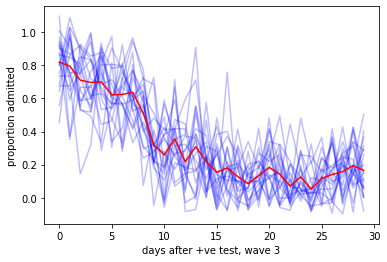

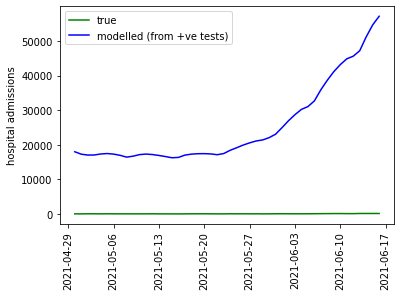

In [19]:
_outputs = np.array(outputs)
plt.clf()
x = list(range(len(pos)))
for y in _outputs:
    #print(sum(y))
    plt.plot(x, y, color="blue", alpha=0.25)
y_avg = []
for i in range(len(y)):
    y_avg.append(np.mean(_outputs[:,i]))
plt.plot(x, y_avg, color="red", alpha=1)
plt.xlabel("days after +ve test, wave %d" % wave)
plt.ylabel("proportion admitted")
plt.savefig("cases_admiss_wave%d.png" % wave, bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

plt.clf()
true, pred = _f(np.array(y_avg), cases_stream, admissions_stream) 
x = _df.dateTime.to_list()[-len(true):]
plt.plot(x, true, color="green", label="true")
plt.plot(x, pred, color="blue", label="modelled (from +ve tests)")
#plt.xlabel("days after start of wave %d" % wave)
plt.ylabel("hospital admissions")
plt.legend()
plt.xticks(rotation=90)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
plt.savefig("cases_admiss_pred_wave%d.png" % wave, bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

cases_admiss[wave] = y_avg

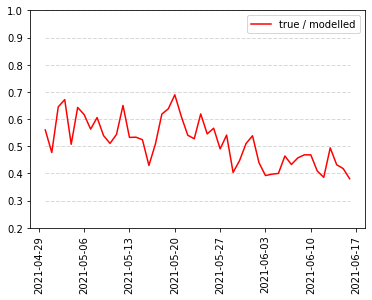

In [44]:
plt.clf()
true, pred = _f(cases_admiss[2], cases_stream, admissions_stream) 
x = _df.dateTime.to_list()[-len(true):]
plt.plot(x, true/pred, color="red", label="true / modelled")
plt.legend()
plt.xticks(rotation=90)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
plt.ylim(0.2,1)
y_locs,_ = plt.yticks()
plt.hlines(locs, x[0], x[-1], color="black", linestyles='dashed', alpha=0.15, linewidth=1)
plt.savefig("cases_admiss_pred_wave%d.png" % wave, bbox_inches='tight', facecolor='white', transparent=False)
plt.show()


2 0.08148076610882382 (7.979743322062764,)


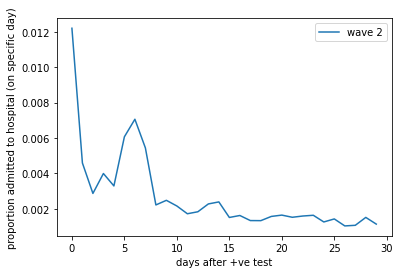

In [10]:
for wave,y_avg in cases_admiss.items():
    print(wave, np.sum(y_avg), center_of_mass(np.array(y_avg[:25])))
          
plt.clf()
x = range(n_dim)
for wave,y_avg in cases_admiss.items():
    plt.plot(x, y_avg, label="wave %d" % wave)
plt.xlabel("days after +ve test")
plt.ylabel("proportion admitted to hospital (on specific day)")
plt.legend()
plt.savefig("cases_admiss_compare.png", bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

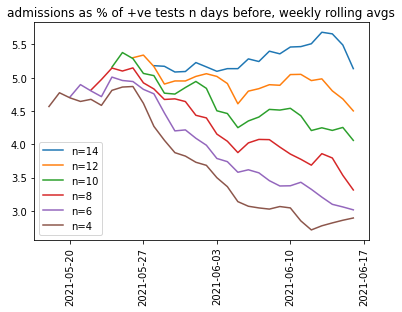

In [11]:
x_dateTimes = df.dateTime.to_list()[-len(x)-11:]

y = {}
admiss_rolling = {}
cases_rolling = {}
for n in [14,12,10,8,6,4]:
    _y1 = []
    _y2 = []
    _y = []
    for dateTime in x_dateTimes[n+7:]:
        dateTime1 = dateTime - datetime.timedelta(days=8)
        dateTime2 = dateTime 
        y1 = np.sum(df[(df.dateTime<=dateTime2) & (df.dateTime>dateTime1)].newAdmissions.to_list())
        _y1.append(y1/7)
        dateTime1 = dateTime1 - datetime.timedelta(days=n)
        dateTime2 = dateTime2 - datetime.timedelta(days=n)
        y2 = np.sum(df[(df.dateTime<=dateTime2) & (df.dateTime>dateTime1)].newCasesBySpecimenDate.to_list())
        _y2.append(y2/7)
        _y.append(y1/y2)
    y[n] = np.array(_y)
    admiss_rolling[n] = np.array(_y1)
    cases_rolling[n] = np.array(_y2)

plt.clf()
plt.title("admissions as % of +ve tests n days before, weekly rolling avgs")
for n,_y in y.items():
    plt.plot(x_dateTimes[n+7:], _y*100, label="n=%d" % n)
true, pred = _f(cases_admiss[2], cases_stream, admissions_stream) 
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(7))
#plt.ylim(2,None)
plt.legend()
plt.savefig("test_vs_admiss_n_days_ago", bbox_inches='tight', facecolor='white', transparent=False)
plt.show()



In [34]:
def _g(x, in_stream, out_stream):
    # model each 1 from in_stream as remaining present for a period with distribution x, in out_stream
    target_out_stream = out_stream[len(x)-1:]
    pred_out_stream = np.convolve(in_stream, x, mode="valid")
    return target_out_stream, pred_out_stream

def g(xs, in_stream=admissions_stream, out_stream=occupancy_stream):
    ret = np.zeros(np.shape(xs)[0])
    for i in range(len(ret)):
        x = xs[i,:]
        target_out_stream, pred_out_stream = _g(x, in_stream, out_stream)
        ret[i] = np.sum(np.abs(pred_out_stream - target_out_stream)) / len(pred_out_stream)
    return ret    

print(_g(np.array([0.5,0.5]), [1,1,1,3,3,3], [0,1,2,3,4,5]))

([1, 2, 3, 4, 5], array([1., 1., 2., 3., 3.]))


In [28]:
n_dim = 30
n_particles = 1000

x_max = np.ones(n_dim)
x_max[0:3] = [1.1,1.1,1.1]
x_min = -0.1*np.ones(n_dim)
options = {'c1': 0.6, 'c2': 0.3, 'w': 0.90}
bounds = (x_min, x_max)
init_pos = None#np.array([x_min for i in range(n_particles)])

outputs = []

In [29]:
for i in range(20):
    optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=n_dim, options=options, bounds=bounds, init_pos=init_pos)
    cost, pos = optimizer.optimize(g, 1000, verbose=True, n_processes=11)
    outputs.append(pos)

2021-06-20 06:59:42,327 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.6, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=373 
2021-06-20 06:59:48,151 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 373.2228968165658, best pos: [ 0.84229737  0.66477826  0.83222766  0.42702336  0.90612617  0.82073498
  0.83561367  0.49273685  0.29186362  0.54745987  0.09190596  0.29033476
  0.34412541  0.44801814  0.16670898  0.04200733  0.08742473  0.17229059
  0.08214612  0.02881622 -0.03056834  0.20644375  0.32452429  0.1312525
 -0.06366402  0.1757323   0.18447016  0.21263882 -0.01141515  0.31390747]
2021-06-20 06:59:48,158 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.6, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=424 
2021-06-20 06:59:53,989 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 423.6949113184142,

2021-06-20 07:00:50,788 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.6, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=367 
2021-06-20 07:00:56,412 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 366.5177420087433, best pos: [ 0.87712938  0.74482147  0.9335299   0.99792952  0.66180078  0.72527981
  0.44366446  0.56362972  0.4556909   0.47556885  0.28263312  0.4014149
  0.12874673  0.19210052  0.21314064  0.09479418  0.30025473  0.01760459
 -0.07815763  0.18013323 -0.02190929  0.03957533  0.24223944  0.18628573
 -0.09469611  0.23037432  0.13285041  0.00146131  0.24417798  0.2937683 ]
2021-06-20 07:00:56,420 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.6, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=423 
2021-06-20 07:01:01,916 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 423.1052146851995,

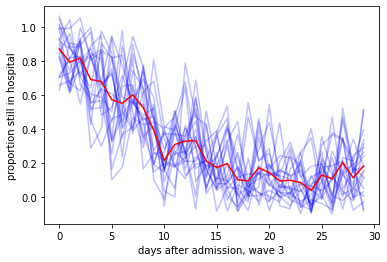

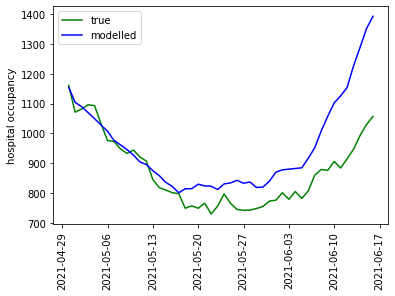

In [35]:
_outputs = np.array(outputs)
plt.clf()
x = list(range(len(pos)))
for y in _outputs:
    plt.plot(x, y, color="blue", alpha=0.25)
y_avg = []
for i in range(len(y)):
    y_avg.append(np.mean(_outputs[:,i]))
plt.plot(x, y_avg, color="red", alpha=1)
plt.xlabel("days after admission, wave %d" % wave)
plt.ylabel("proportion still in hospital")
plt.savefig("admiss_occup_wave%d.png" % wave, bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

plt.clf()
true, pred = _g(np.array(y_avg), admissions_stream, occupancy_stream) 
x = _df.dateTime.to_list()[-len(true):]
plt.plot(x, true, color="green", label="true")
plt.plot(x, pred, color="blue", label="modelled")
plt.ylabel("hospital occupancy")
plt.legend()
plt.xticks(rotation=90)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
plt.savefig("admiss_occup_pred_wave%d.png" % wave, bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

admiss_occup[wave] = y_avg

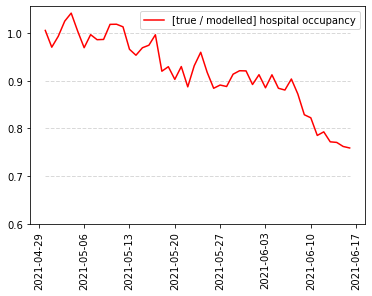

In [50]:
plt.clf()
true, pred = _g(admiss_occup[2], admissions_stream, occupancy_stream) 
x = _df.dateTime.to_list()[-len(true):]
plt.plot(x, true/pred, color="red", label="[true / modelled] hospital occupancy")
plt.legend()
plt.xticks(rotation=90)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
plt.ylim(0.6,None)
y_locs,_ = plt.yticks()
plt.hlines(locs, x[0], x[-1], color="black", linestyles='dashed', alpha=0.15, linewidth=1)
plt.savefig("cases_admiss_pred_wave%d.png" % wave, bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

2 9.86207947123821 (8.603349431592337,)
3 9.828654085696344 (8.795790615230713,)


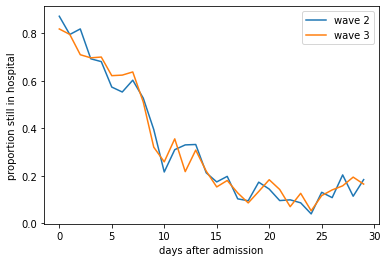

In [32]:
for wave,y_avg in admiss_occup.items():
    print(wave, np.sum(y_avg), center_of_mass(np.array(y_avg)))
          
plt.clf()
x = range(n_dim)
for wave,y_avg in admiss_occup.items():
    plt.plot(x, y_avg, label="wave %d" % wave)
plt.xlabel("days after admission")
plt.ylabel("proportion still in hospital")
plt.legend()
plt.savefig("admiss_occup_compare.png", bbox_inches='tight', facecolor='white', transparent=False)
plt.show()